In [1]:
import os
import sys
import math
import random

from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf

sys.path.append("../../")

from helpers.assess import resolve_sample_weight, make_classification_report
from helpers.split import make_train_test_split, tag_label_feature_split


from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)

In [2]:
file = os.path.join(Path().absolute().parents[1], 'datasets', 'dataset_10_melspecs.pickle.bz2')
df = pd.read_pickle(file)

In [3]:

df1 = df.sample(frac=1) #shuffle


In [4]:
_, (y, le), X = tag_label_feature_split(
    df1, label_format="encoded"
)

In [5]:
def crop_center(X,cropx,cropy):
    _, y,x = X.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return X[:, starty:starty+cropy,startx:startx+cropx]

In [6]:
# extract 2D numpy array from pandas dataframe
X = np.array(list(X.to_numpy()[:,0]))
print(X.shape)
# choosing ~5s clip to make square 96x96 spectrogram frame
# X = crop_center(X, 341, 96) # 683 is around 30s

print(X.shape)

scaler = StandardScaler()
# flatten 2D array to fit to "overall" mean / variance
scaler.fit(X.reshape(-1,1))
# must be reshaped for transformation then restored to original shape
X = scaler.transform(X.reshape(-1, 1)).reshape(X.shape)

# add a dimension from (n, 96, 96) to (n, 96, 96, 1)
X = np.expand_dims(X, axis=-1)

(21351, 96, 683)
(21351, 96, 683)


In [7]:
print(X.shape)

(21351, 96, 683, 1)


In [8]:
X_train, X_test, y_train, y_test = make_train_test_split(
        X, y, test_size=0.1, random_state=10, stratify=y
    )

X_train, X_validation, y_train, y_validation = make_train_test_split(
        X_train, y_train, test_size=0.3, random_state=10, stratify=y_train
    )

class_weight={i:c  for i,c in enumerate(compute_class_weight(class_weight='balanced',classes=le.transform(le.classes_),y=y_train))}

In [9]:
print(np.squeeze(X_train, axis = -1).shape)

(13450, 96, 683)


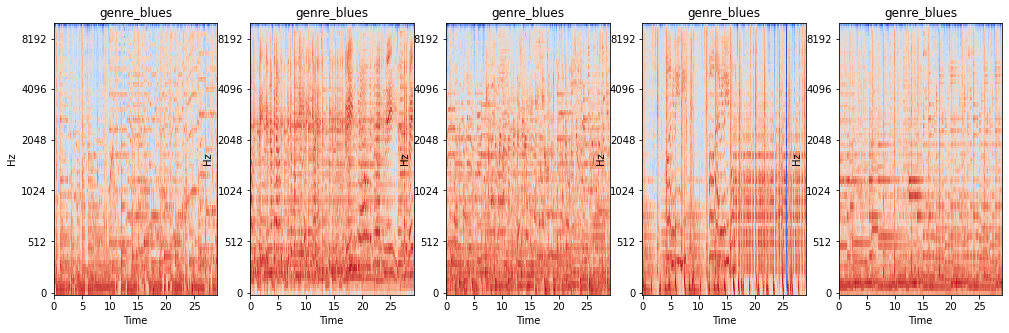

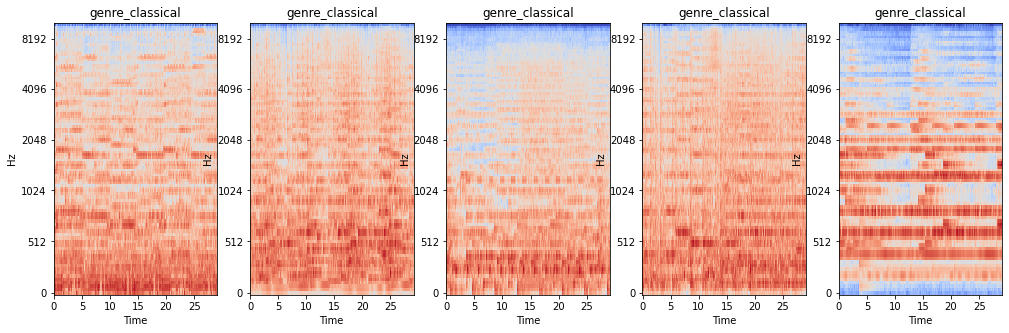

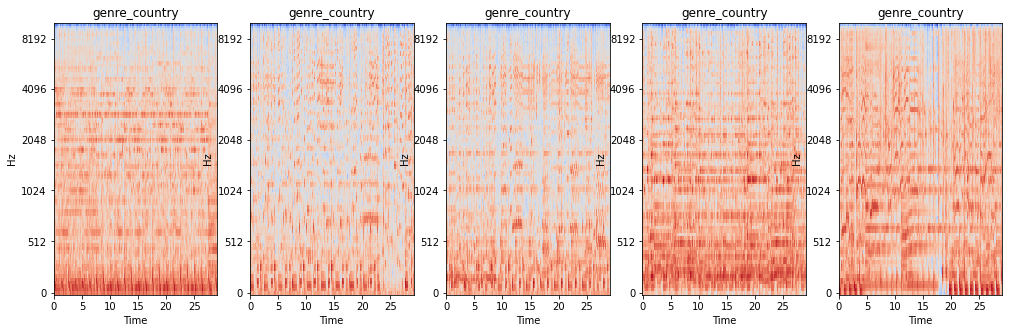

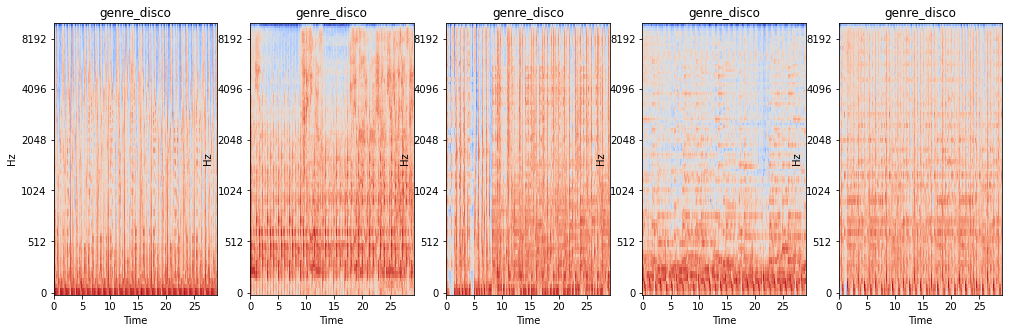

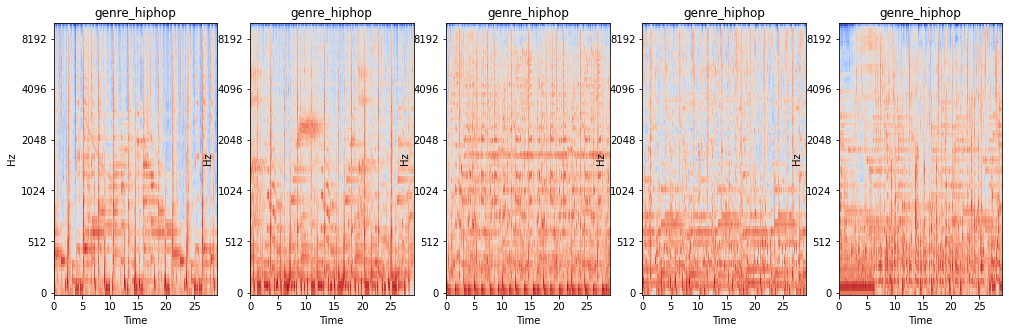

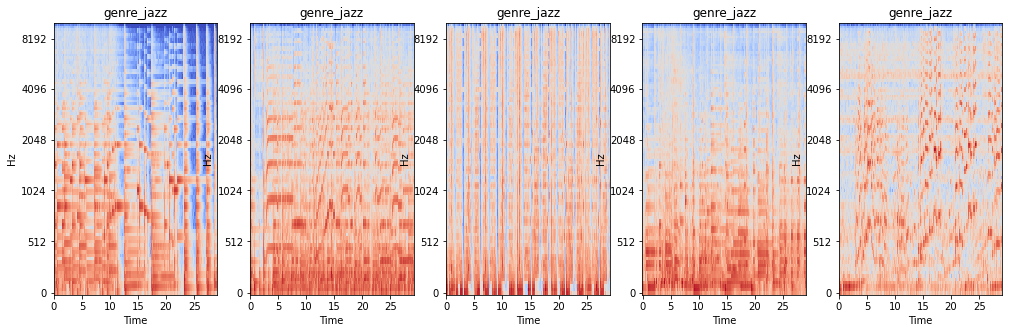

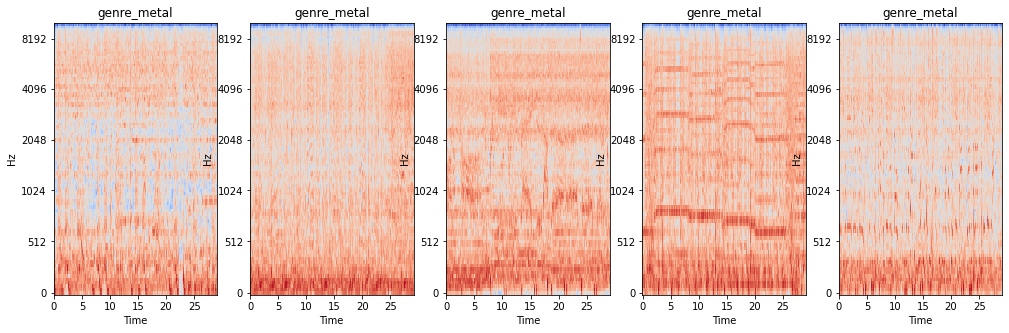

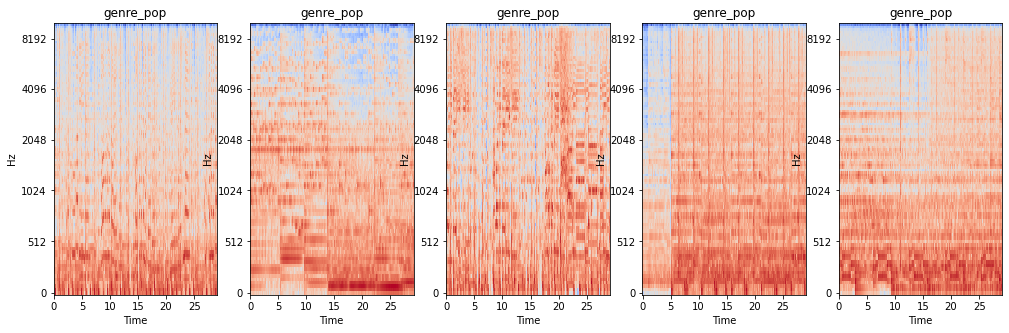

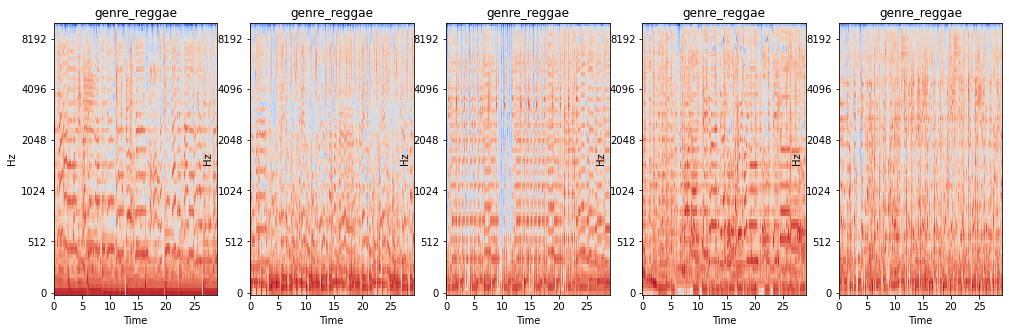

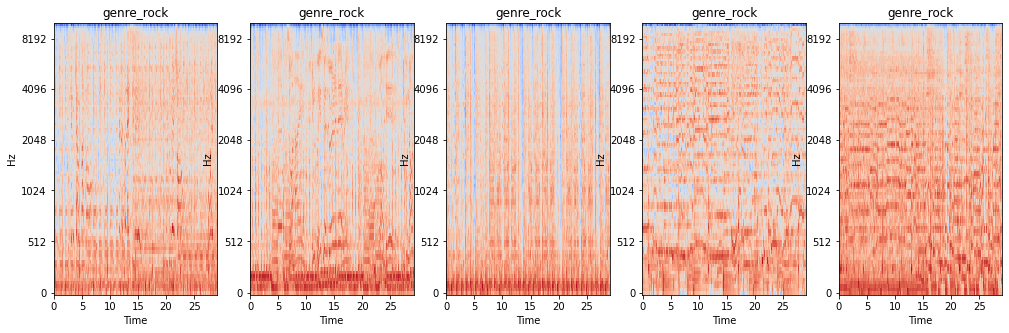

In [10]:
import librosa
import librosa.display

for l in range(10):
    nrows, ncols = 1,5 #print first 4 images
    f, axs = plt.subplots(nrows, ncols, figsize=(17,5))
    tempArr = X_train[y_train == l, :]
    label = le.inverse_transform([l])[0]
    num = 0
    for i in range(ncols):
        img = librosa.display.specshow(np.squeeze(tempArr[num], axis = -1), x_axis='time',
                            y_axis='mel', sr=12000,
                            fmax=10000, ax=axs[i])
        axs[i].set(title=label)
        num += 1
    plt.show()

In [11]:
print(X_train.shape)

(13450, 96, 683, 1)


In [12]:
def build_model(
    filters=[64],
    kernal_size=[16],
    strides=(1, 1),
    padding='same',
    activation='relu',
    pool_size=(2,2),
    batch_normalization=False,
    batch_axis=None,
    dense_units=[1024],
    dropout_rate=0.5,
    input_shape=(None, 96, 96, 1),
    last_activation=None
):
    param = {
        'filters': filters,
        'kernal_size': kernal_size,
        'strides': strides,
        'padding': padding,
        'activation': activation,
        'pool_size': pool_size,
        'dense_units': dense_units,
        'dropout_rate': dropout_rate,
        'input_shape': input_shape,
        'batch_normalization': batch_normalization,
        'batch_axis': batch_axis,
        'last_activation': last_activation
    }
    model = tf.keras.Sequential()

    for i in range(len(filters)):
        model.add(
            tf.keras.layers.Conv2D(
                filters=filters[i],
                kernel_size=kernal_size[i],
                strides=strides,
                padding=padding,
                name=f'conv_{i}',
                activation=activation
            )
        )
        
        if batch_normalization:
            tf.keras.layers.BatchNormalization(batch_axis[i])

        model.add(
            tf.keras.layers.MaxPool2D(
                pool_size=pool_size,
                name=f'pool_{i}'
            )
        )

    model.add(tf.keras.layers.Flatten()) 

    for l in range(len(dense_units)):
        model.add( 
            tf.keras.layers.Dense(
                units=dense_units[l],
                name=f'fc_{l}', 
                activation=activation
            )
        )

    if dropout_rate:
        model.add(
            tf.keras.layers.Dropout(
                rate=dropout_rate
            )
        )

    model.add(
        tf.keras.layers.Dense(
            units=10,
            name='fc_last',
            activation=last_activation
        )
    )

    tf.random.set_seed(1)
    model.build(input_shape=input_shape)
    print(model.summary())

    return model, param



In [27]:
model, param = build_model(
    filters=[96, 64, 32],
    kernal_size=[16, 8, 4],
    strides=(1, 1),
    padding='same',
    activation='relu',
    pool_size=(2,2),
    dense_units=[256, 32],
    dropout_rate=None,
    input_shape=(None, 96, 683, 1)
)

learning_rate = 0.05
epoch = 100
param['learning_rate'] = learning_rate
param['epoch'] = epoch

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 96, 683, 96)       24672     
_________________________________________________________________
pool_0 (MaxPooling2D)        (None, 48, 341, 96)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 48, 341, 64)       393280    
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 24, 170, 64)       0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 24, 170, 32)       32800     
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 12, 85, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32640)            

In [28]:
tf.random.set_seed(1234)
np.random.seed(1234)
hist = model.fit(
    X_train,
    y_train,
    epochs=epoch, 
    validation_data=(X_validation,y_validation),
    class_weight=class_weight,
    # verbose=0
)

Epoch 1/100
421/421 [==============================] - 46s 90ms/step - loss: 24381.3848 - accuracy: 0.0710 - val_loss: 2.2816 - val_accuracy: 0.0389
Epoch 2/100
421/421 [==============================] - 37s 88ms/step - loss: 2.3137 - accuracy: 0.0580 - val_loss: 2.2811 - val_accuracy: 0.0191
Epoch 3/100
421/421 [==============================] - 36s 86ms/step - loss: 2.3128 - accuracy: 0.0570 - val_loss: 2.2976 - val_accuracy: 0.0727
Epoch 4/100
421/421 [==============================] - 35s 84ms/step - loss: 2.3126 - accuracy: 0.0473 - val_loss: 2.3064 - val_accuracy: 0.0727
Epoch 5/100
421/421 [==============================] - 36s 85ms/step - loss: 2.3115 - accuracy: 0.0607 - val_loss: 2.3085 - val_accuracy: 0.0219
Epoch 6/100
421/421 [==============================] - 35s 84ms/step - loss: 2.3128 - accuracy: 0.0589 - val_loss: 2.3626 - val_accuracy: 0.0191
Epoch 7/100
421/421 [==============================] - 36s 85ms/step - loss: 2.3111 - accuracy: 0.0970 - val_loss: 2.3728 - va

Text(0.5, 1.0, 'Accuracy')

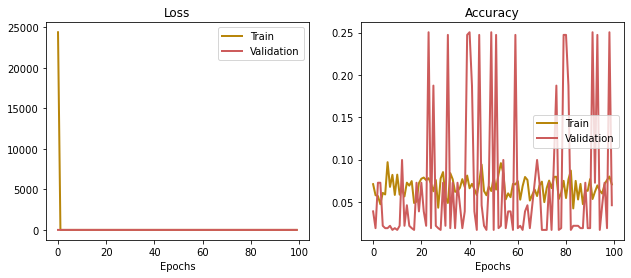

In [29]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.5,0.7)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss')

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.7,0.8)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy')

In [30]:
# y_pred = model.predict(X_test)
# class_y = np.argmax(y_pred, axis=1)

In [31]:
# print(X_test)

In [32]:
# make_classification_report(
#     y_true=y_test,
#     y_pred=class_y,
#     model=model,
#     x = X_test,
#     save_result=True,
#     model_name='CNN_melspec_5s_1',
#     dataset_name='dataset_10_melspecs',
#     phase='train',
#     additional_result_param=param,
#     repeat=False,
#     sample_weight=class_weight,
#     result_filename='alvin_melspec_CNN'
# )

In [34]:
model, param = build_model(
    # filters=[96, 64, 32],
    # kernal_size=[16, 8, 4],
    # strides=(1, 1),
    # padding='same',
    # activation='relu',
    # pool_size=(2,2),
    # dense_units=[256, 32],
    # dropout_rate=None,
    input_shape=(None, 96, 683, 1)
)

learning_rate = 0.05
epoch = 100
param['learning_rate'] = learning_rate
param['epoch'] = epoch

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

hist = model.fit(
    X_train,
    y_train,
    epochs=epoch, 
    validation_data=(X_validation,y_validation),
    class_weight=class_weight,
    # verbose=0
)

# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.5,0.7)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss')

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.7,0.8)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy')

ResourceExhaustedError: OOM when allocating tensor with shape[1047552,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

using model from https://towardsdatascience.com/music-genre-recognition-using-convolutional-neural-networks-cnn-part-1-212c6b93da76

In [13]:
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 96, 683, 8)        80        
_________________________________________________________________
pool_0 (MaxPooling2D)        (None, 48, 341, 8)        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 48, 341, 16)       1168      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 24, 170, 16)       0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 24, 170, 32)       4640      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 12, 85, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 12, 85, 64)       

c:\Users\alvin\anaconda3\envs\W207\lib\site-packages\keras\backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


421/421 [==============================] - 14s 15ms/step - loss: 1.9513 - accuracy: 0.3217 - get_f1: 7.2214 - val_loss: 1.6120 - val_accuracy: 0.3964 - val_get_f1: 5.2586
Epoch 2/100
421/421 [==============================] - 5s 12ms/step - loss: 1.7144 - accuracy: 0.3949 - get_f1: 5.4359 - val_loss: 1.6303 - val_accuracy: 0.4114 - val_get_f1: 5.2819
Epoch 3/100
421/421 [==============================] - 5s 12ms/step - loss: 1.6074 - accuracy: 0.4283 - get_f1: 4.7948 - val_loss: 1.5308 - val_accuracy: 0.4720 - val_get_f1: 5.1157
Epoch 4/100
421/421 [==============================] - 5s 12ms/step - loss: 1.5015 - accuracy: 0.4570 - get_f1: 4.3054 - val_loss: 1.4909 - val_accuracy: 0.4583 - val_get_f1: 4.2851
Epoch 5/100
421/421 [==============================] - 5s 12ms/step - loss: 1.4131 - accuracy: 0.4874 - get_f1: 3.9760 - val_loss: 1.5154 - val_accuracy: 0.4435 - val_get_f1: 4.3698
Epoch 6/100
421/421 [==============================] - 5s 12ms/step - loss: 1.3117 - accuracy: 0.4979

Text(0.5, 1.0, 'Accuracy')

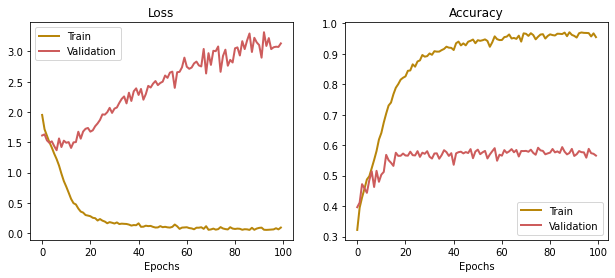

In [15]:
model, param = build_model(
    filters=[8, 16, 32, 64, 128],
    kernal_size=[(3,3), (3,3), (3,3), (3,3), (3,3)],
    strides=(1, 1),
    padding='same',
    activation='relu',
    batch_normalization=True,
    batch_axis=[3, 3, 3, -1, -1],
    pool_size=(2,2),
    dense_units=[],
    dropout_rate=0.3,
    input_shape=(None, 96, 683, 1),
    last_activation='softmax'
)

learning_rate = 0.0005
epoch = 100

param['learning_rate'] = learning_rate
param['epoch'] = epoch

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy', get_f1]
)

hist = model.fit(
    X_train,
    y_train,
    epochs=epoch, 
    validation_data=(X_validation,y_validation),
    class_weight=class_weight,
    # verbose=0
)

# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.5,0.7)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss')

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.7,0.8)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy')

In [16]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [17]:
make_classification_report(
    y_true=y_test,
    y_pred=y_pred,
    model=model,
    x = X_test,
    save_result=True,
    label_encoder=le,
    model_name='CNN_melspec_30s_1',
    dataset_name='dataset_10_melspecs',
    phase='train',
    additional_result_param=param,
    repeat=True,
    result_filename='alvin_melspec_CNN.json'
)

c:\Users\alvin\OneDrive - UCLA IT Services\Berkeley MIDS\W207\final_project\member_workspaces\alvin\..\..\results\alvin_melspec_CNN.json
file exist, reading json
record saved


'                   precision  recall  f1-score  support   mcc\n                                                             \n      genre_blues       0.05    0.02      0.03       47  0.02\n  genre_classical       0.83    0.84      0.84      528  0.78\n    genre_country       0.24    0.32      0.27       41  0.26\n      genre_disco       0.27    0.19      0.23       36  0.22\n     genre_hiphop       0.49    0.77      0.60      213  0.56\n       genre_jazz       0.49    0.50      0.49      155  0.45\n      genre_metal       0.54    0.46      0.50       83  0.48\n        genre_pop       0.49    0.37      0.42      534  0.27\n     genre_reggae       0.65    0.42      0.51       99  0.51\n       genre_rock       0.49    0.58      0.53      400  0.41\n                                                             \n         accuracy                         0.57     2136  0.48\n        macro avg       0.45    0.45      0.44     2136      \n     weighted avg       0.57    0.57      0.56     213

In [19]:
make_classification_report(
    y_true=y_test,
    y_pred=y_pred,
    model=model,
    x = X_test,
    label_encoder=le,
    print_report=True
)

                   precision  recall  f1-score  support   mcc
                                                             
      genre_blues       0.05    0.02      0.03       47  0.02
  genre_classical       0.83    0.84      0.84      528  0.78
    genre_country       0.24    0.32      0.27       41  0.26
      genre_disco       0.27    0.19      0.23       36  0.22
     genre_hiphop       0.49    0.77      0.60      213  0.56
       genre_jazz       0.49    0.50      0.49      155  0.45
      genre_metal       0.54    0.46      0.50       83  0.48
        genre_pop       0.49    0.37      0.42      534  0.27
     genre_reggae       0.65    0.42      0.51       99  0.51
       genre_rock       0.49    0.58      0.53      400  0.41
                                                             
         accuracy                         0.57     2136  0.48
        macro avg       0.45    0.45      0.44     2136      
     weighted avg       0.57    0.57      0.56     2136      
        

'                   precision  recall  f1-score  support   mcc\n                                                             \n      genre_blues       0.05    0.02      0.03       47  0.02\n  genre_classical       0.83    0.84      0.84      528  0.78\n    genre_country       0.24    0.32      0.27       41  0.26\n      genre_disco       0.27    0.19      0.23       36  0.22\n     genre_hiphop       0.49    0.77      0.60      213  0.56\n       genre_jazz       0.49    0.50      0.49      155  0.45\n      genre_metal       0.54    0.46      0.50       83  0.48\n        genre_pop       0.49    0.37      0.42      534  0.27\n     genre_reggae       0.65    0.42      0.51       99  0.51\n       genre_rock       0.49    0.58      0.53      400  0.41\n                                                             \n         accuracy                         0.57     2136  0.48\n        macro avg       0.45    0.45      0.44     2136      \n     weighted avg       0.57    0.57      0.56     213